In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv
/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv


In [2]:
!pip install Datasets

In [3]:
import pandas as pd
import re
import torch
import os
from bs4 import BeautifulSoup
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader
import datasets
from datasets import Dataset, DatasetDict
from tqdm import tqdm

In [4]:
# Load ALBERT tokenizer and model
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

# Load data
df_train = pd.read_csv('/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv')
df_valid = pd.read_csv('/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv')
# Preprocess data
df_train = df_train.filter(['Title', 'Body', 'Tags', 'Y'])
df_train['Y'] = df_train['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

df_valid = df_valid.filter(['Title', 'Body', 'Tags', 'Y'])
df_valid['Y'] = df_valid['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
class Preprocessing:
    def __get_body_tag_text(self, text):
        soup = BeautifulSoup(text, features='xml')
        return soup.get_text()

    def __lower_and_punc_removal(self, text):
        text = text.lower()
        text = re.sub(r'[^(a-zA-Z)\s]', '', text)
        return text

    def __init__(self, df):
        self.df = df
        self.df['Body_Between_Tags'] = self.df['Body'].apply(self.__get_body_tag_text)
        self.df['Final_clean'] = self.df['Body_Between_Tags'].apply(self.__lower_and_punc_removal)

PreprocessedObject_train = Preprocessing(df=df_train)
PreprocessedObject_valid = Preprocessing(df=df_valid)

PreprocessedObject_train.df.dropna(inplace=True)
PreprocessedObject_valid.df.dropna(inplace=True)
PreprocessedObject_train.df.reset_index(inplace=True)
PreprocessedObject_valid.df.reset_index(inplace=True)

df_train_final = PreprocessedObject_train.df
df_valid_final = PreprocessedObject_valid.df

df_train_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)
df_valid_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)


# Retain the label column
df_train_final = df_train_final[['Final_clean', 'Y']]
df_valid_final = df_valid_final[['Final_clean', 'Y']]

/tmp/ipykernel_34/907729622.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')
/tmp/ipykernel_34/907729622.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')


In [6]:
# Create DatasetDict
datasets_train_test = DatasetDict({
    "train": Dataset.from_pandas(df_train_final),
    "test": Dataset.from_pandas(df_valid_final)
})


In [7]:
# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["Final_clean"], padding="max_length", truncation=True)

tokenized_datasets = datasets_train_test.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Final_clean'])
tokenized_datasets = tokenized_datasets.rename_column("Y", "labels")
tokenized_datasets.set_format("torch")


Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [8]:
# Create dataloaders
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)

In [9]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
print(df_train_final.head())
print(df_valid_final.head())

                                         Final_clean  Y
0  im already familiar with repeating tasks every...  0
1  id like to understand why java  optionals were...  2
2  i am attempting to overlay a title over an ima...  2
3  the question is very simple but i just could n...  2
4  im using custom floatingactionmenu i need to i...  2
                                         Final_clean  Y
0                                                     1
1                                                     1
2  im trying to extract us states from wiki url a...  2
3                                                     1
4                                                     1


In [11]:
print(tokenized_datasets)
print(tokenized_datasets['test'])  # Use the correct key 'test' to access the test dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15000
    })
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 15000
})


In [12]:
import torch
from tqdm import tqdm

# Move model to appropriate device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(total=num_epochs * len(train_dataloader))
model.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        if batch is not None and isinstance(batch, dict) and all(v is not None for v in batch.values()):  # Check if batch is not None and contains valid data
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

progress_bar.close()


Epoch 1/1, Loss: 0.1865: 100%|██████████| 5625/5625 [41:19<00:00,  2.27it/s]


In [13]:
correct = 0
total = 0
model.eval()

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    correct += torch.sum(predictions == batch["labels"]).item()
    total += len(predictions)


accuracy = correct / total
print("Accuracy:", accuracy)

Accuracy: 0.8511333333333333


In [15]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


2024-06-30 10:15:25.135318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 10:15:25.135430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 10:15:25.263866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


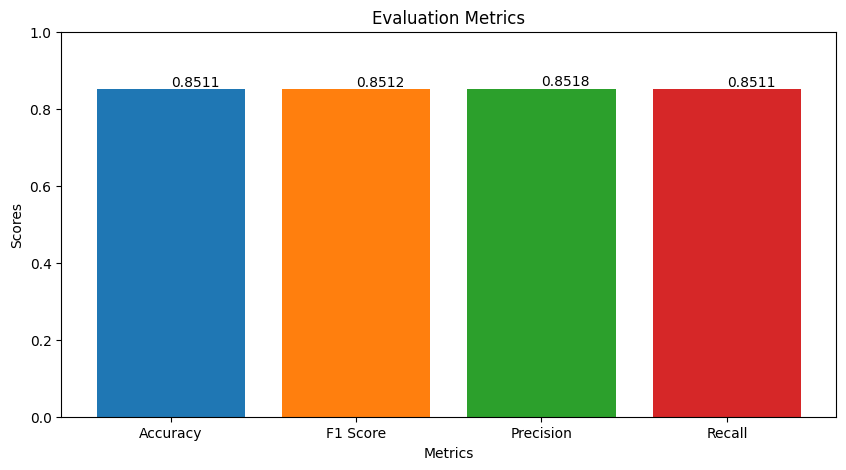

In [16]:
import evaluate
import matplotlib.pyplot as plt

# Initialize the metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

model.eval()

# Evaluate the model on the evaluation dataset
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Add batch results to the metrics
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    f1_metric.add_batch(predictions=predictions, references=batch["labels"])
    precision_metric.add_batch(predictions=predictions, references=batch["labels"])
    recall_metric.add_batch(predictions=predictions, references=batch["labels"])

# Compute the metrics
accuracy = accuracy_metric.compute()['accuracy']
f1 = f1_metric.compute(average='weighted')['f1']
precision = precision_metric.compute(average='weighted')['precision']
recall = recall_metric.compute(average='weighted')['recall']

# Store the metrics in a dictionary for easy plotting
metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall
}

# Colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # You can customize these colors

# Plot the metrics as a bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Assuming metrics are between 0 and 1

# Add values on top of the bars for better visualization
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')  # va: vertical alignment

plt.show()


In [20]:

import pandas as pd
from IPython.display import FileLink



# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Score': [accuracy, f1, precision, recall]
})

# Save to CSV file
metrics_df.to_csv('metrics_alberta.csv', index=False)

# Create a download link for the CSV file
FileLink(r'metrics_alberta.csv')


/kaggle/working/metrics_alberta.csv

In [21]:
import json

# Assuming `metrics` is a dictionary containing your metrics
metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall
}

# Save the metrics to a JSON file in Kaggle environment
metrics_filename = 'metrics_alberta.json'
with open(metrics_filename, 'w') as f:
    json.dump(metrics, f)

# Download the JSON file to your local machine
from IPython.display import FileLink
FileLink(r'metrics_alberta.json')

/kaggle/working/metrics_alberta.json

In [22]:
import torch

# Assuming `model` is your trained model
# Save the model's state dictionary to a file in Kaggle environment
model_path = 'trained_model_alberta.pth'
torch.save(model.state_dict(), model_path)

# Download the model file to your local machine
from IPython.display import FileLink
FileLink(r'trained_model_alberta.pth')

/kaggle/working/trained_model_alberta.pth

In [23]:
!pip install gradio

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 88.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 99.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.5 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=1dfcef9f32fe08dc8e3ad072a93f964e5aa509503e4cc8562526a6ee95d867bb
  Stored in directory: /root/.cache/pip/wheels/bd/65/9a/671fc6dcde07d4418df0c592f8df512b26d7a0029c2a23dd81
Successfully built ffmpy
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting unins

In [25]:
import torch
from transformers import AlbertForSequenceClassification, AlbertTokenizer
import gradio as gr

# Load the model and tokenizer for ALBERT
model_path = '/kaggle/working/trained_model_alberta.pth'
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)  # Adjust num_labels based on your task
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Load state_dict
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Mapping from numerical predictions to original labels
label_map = {0: 'LQ_CLOSE', 1: 'LQ_EDIT', 2: 'HQ'}

def classify_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    return label_map[predicted_class]

# Create Gradio interface
iface = gr.Interface(
    fn=classify_text,
    inputs=gr.Textbox(lines=2, label="Enter text to classify"),
    outputs=gr.Label(num_top_classes=3),
    title="ALBERT Text Classification",
    description="Enter text and classify its category using a fine-tuned ALBERT model."
)

# Launch the interface
iface.launch()


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://47d7ca941a627ed898.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
